In [1]:
%autosave 100
%reset

Autosaving every 100 seconds

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.


In [76]:
%matplotlib inline

In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, rcParams
import matplotlib
from IPython.display import HTML

In [5]:
def x0(z):
    return 0 if z == 0 else 1

def t0(z):
    return T_m if z == 0 else T_0

def W_(X, T):
    return [-K * X[i]**alpha * math.exp(-E / (R * T[i])) for i in range(len(X))]

In [6]:
def solve(X_old, T_old):
    # predictor X
    alpha_ = np.zeros([len(X_old)], dtype = float)
    beta_  = np.zeros([len(X_old)], dtype = float)
    
    a_ = D / dz**2
    #b_ = -2*D / dz**2 - 1. / dt
    c_ = D / dz**2
    d_  = np.zeros([len(X_old)], dtype = float)
    b_  = np.zeros([len(X_old)], dtype = float)
    for i in range(len(X_old)):
        b_[i] = -2*D / dz**2 - 1. / dt - K * math.exp(-E/(R*T_old[i])) 
        d_[i] = - X_old[i] / dt
    
    alpha_[0] = -c_ / b_[0]
    beta_[0] = d_[0] / b_[0]
    for i in range(1, len(alpha_)):
        alpha_[i] = -c_ / (a_ * alpha_[i - 1] + b_[i])
        beta_[i] = (d_[i] - a_ * beta_[i - 1]) / (a_ * alpha_[i - 1] + b_[i])
    
    X_pred = np.zeros([len(X_old)], dtype = float)
    X_pred[-1] = (d_[-1] - a_ * beta_[-2]) / (a_ * alpha_[-2] + b_[-1] + c_)
    for i in range(len(X_pred) - 1, 0, -1):
        X_pred[i-1] = alpha_[i-1] * X_pred[i] + beta_[i-1]     
        
    # predictor T
    alpha_ = np.zeros([len(X_old)], dtype = float)
    beta_  = np.zeros([len(X_old)], dtype = float)
    
    a_ = lambd / (po * C * dz**2)
    b_ = -2*lambd / (po * C * dz**2) - 1. / dt
    c_ = lambd / (po * C * dz**2)
    d_  = np.zeros([len(X_old)], dtype = float)
    for i in range(len(X_old)):
        d_[i] = -Q / C * K * X_pred[i]**alpha * math.exp(-E/(R*T_old[i])) - T_old[i] / dt 
    d_[0] -= a_ * T_m
    
    
    alpha_[0] = -c_ / b_
    beta_[0] = d_[0] / b_
    for i in range(1, len(alpha_)):
        alpha_[i] = -c_ / (a_ * alpha_[i - 1] + b_)
        beta_[i] = (d_[i] - a_ * beta_[i - 1]) / (a_ * alpha_[i - 1] + b_)
    
    T_pred = np.zeros([len(X_old)], dtype = float)
    T_pred[-1] = (d_[-1] - a_ * beta_[-2]) / (a_ * alpha_[-2] + b_ + c_)
    for i in range(len(T_pred) - 1, 0, -1):
        T_pred[i-1] = alpha_[i-1] * T_pred[i] + beta_[i-1] 
    #T_pred[0] = (d_[0] - c_ * T_pred[1]) / (a_ + b_)
        
    
    
    return (X_pred, T_pred)

In [7]:
# регулярный режим

T_0 = 293         # K
Q = 7.9 * 10**5     # Дж/кг 
C = 1980          # Дж/кг*К 
T_m = T_0 + Q / C # K
K = 1.6 * 10**6   # 1/с
E = 8 * 10**4     # Дж/моль
R = 8.314         # Дж/моль*К
alpha = 1         # 
po = 830           # кг/м^3
lambd = 0.13      # Дж/м*с*К
D = lambd / (po * C)# 8 * 10**(-12) # м^2/с

beta = R * T_m / E
gamma = R * T_m**2 / (E * (T_m - T_0))

U = ( 2*K*lambd / (Q*po*(T_m - T_0)) * (R*T_m**2/E)**2 * math.exp(-E/(R*T_m)) * T_0 / T_m ) ** 0.5
dd = D / U
dh = lambd / (po * C * U)
dr = dh * beta

dz = dr / 4
L  = 10 * dh
steps = round(L / dz) + 1

dt = dz / U
times = 500 #math.floor(L / U / dt)

print('D =',"%.2e" % D, 'м^2/с')
print('K =',"%.2e" % K, '1/с')
print('E =',E, 'Дж/моль')
print('U =',"%.6f" % U, 'м/с')
print('dd =',"%.6f" % dd, 'м')
print('dh =',"%.6f" % dh, 'м')
print('dr =',"%.6f" % dr, 'м')
print('dz =',"%.6f" % dz, 'м')
print('L =',"%.3f" % L, 'м')
print('steps =',steps)
print('dt =',"%.2f" % dt, 'с')
print('times =',times)

D = 7.91e-08 м^2/с
K = 1.60e+06 1/с
E = 80000 Дж/моль
U = 0.000039 м/с
dd = 0.002026 м
dh = 0.002026 м
dr = 0.000146 м
dz = 0.000036 м
L = 0.020 м
steps = 557
dt = 0.93 с
times = 500


(904,) (300, 904)


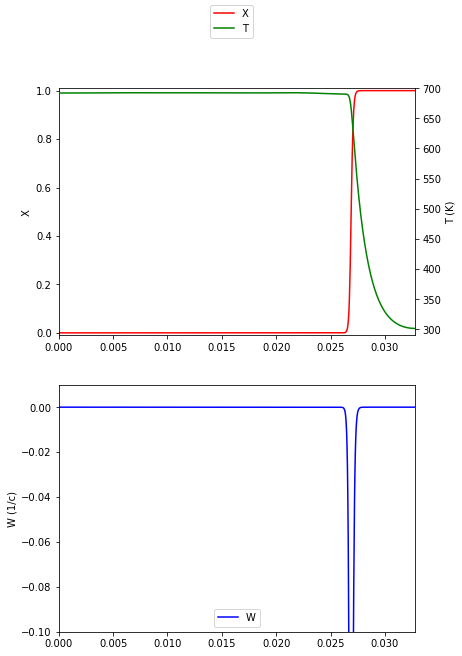

In [90]:
zs = np.arange(0, L, dz)
T = np.zeros([times, steps], dtype = float)
X = np.zeros([times, steps], dtype = float)
W = np.zeros([times, steps], dtype = float)
print(np.shape(zs), np.shape(T))

for (i,z) in enumerate(zs):
    X[0,i] = x0(z)
    T[0,i] = t0(z)
W[0,:] = W_(X[0,:], T[0,:])

fig1 = plt.figure(figsize=(6.4, 10))
ax1 = fig1.add_subplot(2,1,1)
ax2 = fig1.add_axes(ax1.get_position(), frameon=False)
ax3 = fig1.add_subplot(2,1,2)
 
xlims = 0, L
ax1.set_xlim(*xlims)
ax2.set_xlim(*xlims)
ax3.set_xlim(*xlims)


ax1.set_ylim(-0.01, 1.01)
ax2.set_ylim(290, 700)
ax1.set_ylabel('X')
ax2.set_ylabel('T (K)')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_xticks([])

fig1.legend([l1, l2], ['X', 'T'], loc = 9)

ax3.set_ylim(-0.1, 0.01)
ax3.set_ylabel('W (1/c)')

ax3.legend([l3], ['W'], loc = 8)

    
l1, = ax1.plot([], [], label = 'X', color = 'red')
l2, = ax2.plot([], [], label = 'T', color = 'green')
l3, = ax3.plot([], [], label = 'W', color = 'blue')

def update(time):
    if time > 0:
        X[time, 0] = 0
        T[time, 0] = T_m
        (X[time, 1:-1], T[time, 1:-1]) = solve(X[time - 1, 1:-1], T[time - 1, 1:-1])
        X[time, -1] = X[time, -2]
        T[time, -1] = T[time, -2]
        W[time, : ] = W_(X[time, :], T[time, :])
    if (time % 5 == 0):        
        l1.set_data(zs, X[time,:])
        l2.set_data(zs, T[time,:])
        l3.set_data(zs, W[time,:])
    return l1, l2, l3

ani = FuncAnimation(fig1, update, frames=range(times), blit=True)

ani

In [9]:
# D=8e-12; W in [-0.5, 0.01] stable
# K *= 10; W in [-5, 0.01] a bit of fluctuation; draw each 20 steps
# const should be 1.46
# E=10 * 10**4; K *= 32; W in [-0.5, 0.01] a bit of fluctuation; draw each 20 steps
# E=12 * 10**4; K *= 1050; W in [-0.5, 0.01] more fluctuations; draw each 25 steps
# E=13 * 10**4; K *= 6000; W in [-0.5, 0.01] fluctuations; draw each 20 steps

T_0 = 293         # K
Q = 7.9 * 10**5     # Дж/кг 
C = 1980          # Дж/кг*К 
T_m = T_0 + Q / C # K
K = 6000 * 1.6 * 10**6   # 1/с
E = 13 * 10**4     # Дж/моль
R = 8.314         # Дж/моль*К
alpha = 1         # 
po = 830           # кг/м^3
lambd = 0.13      # Дж/м*с*К
D = 8e-12         # 8 * 10**(-12) # м^2/с

beta = R * T_m / E
gamma = R * T_m**2 / (E * (T_m - T_0))

U = ( 2*K*lambd / (Q*po*(T_m - T_0)) * (R*T_m**2/E)**2 * math.exp(-E/(R*T_m)) * T_0 / T_m ) ** 0.5
dd = D / U
dh = lambd / (po * C * U)
dr = dh * beta

dz = dr / 4
L  = 10 * dh
steps = round(L / dz)

dt = dz / U
times = 300 

print('D =',"%.2e" % D, 'м^2/с')
print('K =',"%.2e" % K, '1/с')
print('E =',E, 'Дж/моль')
print('U =',"%.6f" % U, 'м/с')
print('dd =',"%.6f" % dd, 'м')
print('dh =',"%.6f" % dh, 'м')
print('dr =',"%.6f" % dr, 'м')
print('dz =',"%.6f" % dz, 'м')
print('L =',"%.3f" % L, 'м')
print('steps =',steps)
print('dt =',"%.2f" % dt, 'с')
print('times =',times)

print(K*math.exp(-E/(R*T_m)))

D = 8.00e-12 м^2/с
K = 9.60e+09 1/с
E = 130000 Дж/моль
U = 0.000024 м/с
dd = 0.000000 м
dh = 0.003278 м
dr = 0.000145 м
dz = 0.000036 м
L = 0.033 м
steps = 904
dt = 1.50 с
times = 300
1.4753928674069308


In [10]:
def solve(X_old, T_old):
    # predictor X
    alpha_ = np.zeros([len(X_old)], dtype = float)
    beta_  = np.zeros([len(X_old)], dtype = float)
    
    a_ = D / dz**2
    #b_ = -2*D / dz**2 - 1. / dt
    c_ = D / dz**2
    d_  = np.zeros([len(X_old)], dtype = float)
    b_  = np.zeros([len(X_old)], dtype = float)
    for i in range(len(X_old)):
        b_[i] = -2*D / dz**2 - 1. / dt - K * math.exp(-E/(R*T_old[i])) 
        d_[i] = - X_old[i] / dt
    
    alpha_[0] = -c_ / b_[0]
    beta_[0] = d_[0] / b_[0]
    for i in range(1, len(alpha_)):
        alpha_[i] = -c_ / (a_ * alpha_[i - 1] + b_[i])
        beta_[i] = (d_[i] - a_ * beta_[i - 1]) / (a_ * alpha_[i - 1] + b_[i])
    
    X_pred = np.zeros([len(X_old)], dtype = float)
    X_pred[-1] = (d_[-1] - a_ * beta_[-2]) / (a_ * alpha_[-2] + b_[-1] + c_)
    for i in range(len(X_pred) - 1, 0, -1):
        X_pred[i-1] = alpha_[i-1] * X_pred[i] + beta_[i-1]     
        
    # predictor T
    alpha_ = np.zeros([len(X_old)], dtype = float)
    beta_  = np.zeros([len(X_old)], dtype = float)
    
    a_ = lambd / (po * C * dz**2)
    b_ = -2*lambd / (po * C * dz**2) - 1. / dt
    c_ = lambd / (po * C * dz**2)
    d_  = np.zeros([len(X_old)], dtype = float)
    for i in range(len(X_old)):
        d_[i] = -Q / C * K * X_pred[i]**alpha * math.exp(-E/(R*T_old[i])) - T_old[i] / dt 
    d_[0] -= a_ * T_m
    
    
    alpha_[0] = -c_ / b_
    beta_[0] = d_[0] / b_
    for i in range(1, len(alpha_)):
        alpha_[i] = -c_ / (a_ * alpha_[i - 1] + b_)
        beta_[i] = (d_[i] - a_ * beta_[i - 1]) / (a_ * alpha_[i - 1] + b_)
    
    T_pred = np.zeros([len(X_old)], dtype = float)
    T_pred[-1] = (d_[-1] - a_ * beta_[-2]) / (a_ * alpha_[-2] + b_ + c_)
    for i in range(len(T_pred) - 1, 0, -1):
        T_pred[i-1] = alpha_[i-1] * T_pred[i] + beta_[i-1] 
    #T_pred[0] = (d_[0] - c_ * T_pred[1]) / (a_ + b_)
        
    
    
    return (X_pred, T_pred)

In [17]:
rcParams['animation.html']='html5'

(904,) (300, 904)


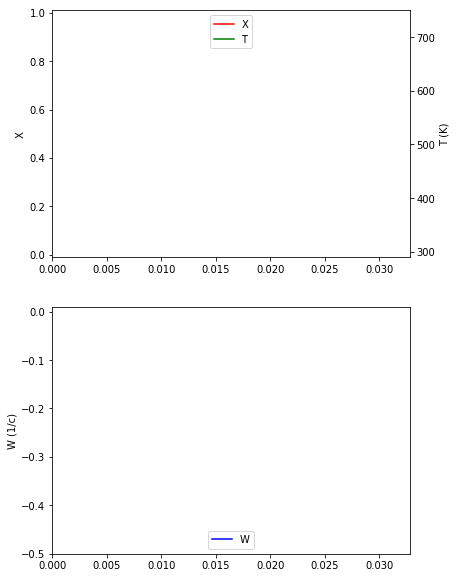

In [83]:
zs = np.arange(0, L, dz)
T = np.zeros([times, steps], dtype = float)
X = np.zeros([times, steps], dtype = float)
W = np.zeros([times, steps], dtype = float)
print(np.shape(zs), np.shape(T))

for (i,z) in enumerate(zs):
    X[0,i] = x0(z)
    T[0,i] = t0(z)
W[0,:] = W_(X[0,:], T[0,:])

xlims = 0, L
fig1 = plt.figure(figsize=(6.4, 10))
ax1 = fig1.add_subplot(2,1,1)
ax1.set_xlim(*xlims)
ax2 = fig1.add_axes(ax1.get_position(), frameon=False)
ax2.set_xlim(*xlims)

ax1.set_ylim(-0.01, 1.01)
ax2.set_ylim(290, 750)
ax1.set_ylabel('X')
ax2.set_ylabel('T (K)')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_xticks([])

ax1.legend([l1, l2], ['X', 'T'], loc = 9)
       
#W всегда отрицательно

ax3 = fig1.add_subplot(2,1,2)
ax3.legend([l3], ['W'], loc = 8)

ax3.set_xlim(*xlims)
ax3.set_ylim(-0.5, 0.01)
ax3.set_ylabel('W (1/c)')


l1, = ax1.plot([], [], label = 'X', color = 'red')
l2, = ax2.plot([], [], label = 'T', color = 'green')
l3, = ax3.plot([], [], label = 'W', color = 'blue')

def update(time):
    if time > 0:
        X[time, 0] = 0
        T[time, 0] = T_m
        (X[time, 1:-1], T[time, 1:-1]) = solve(X[time - 1, 1:-1], T[time - 1, 1:-1])
        X[time, -1] = X[time, -2]
        T[time, -1] = T[time, -2]
        W[time, : ] = W_(X[time, :], T[time, :])
    
    l1.set_data(zs, X[time, :])
    l2.set_data(zs, T[time,:])
    l3.set_data(zs, W[time,:])
    return l1, l2, l3

In [84]:
ani = FuncAnimation(fig1, update, frames=range(times), blit=True)

ani